<font size=4> Привет, Иван! Меня зовут Алан Созанов, будем обмениваться с тобой опытом для успешного прохождения задания! Если не против, предлагаю общаться на ты (иначе дай знать, и перейдем на «вы»). Свои рекомендации буду оформлять в виде комментариев в Markdown ячейках:<br><strong>
    <li> <font color='red'> «❌ красный цвет» </font> – важно исправить или внести пояснения
    <li> <font color='orange'> «⚠️желтый цвет» </font>  – учесть, но можно не исправлять 
    <li> <font color='green'> «✔️ зеленый цвет» </font> – все отлично, плюс альтернативные пути решения задачи
    <li>   <font color='steelblue'>«синий цвет» </font> - просто текст комментария
     </strong>
<br> Количество символов (✔️, ⚠️, ❌) будет соответствовать версии комментария. Прошу при внесении правок мои комментарии не удалять, а свои писать в соседних ячейках и выделять удобным цветом. Так коммуникация будет проходить эффективнее 👍.<br>
</font>

# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания (значение метрики RMSE должно быть меньше 2500);
- скорость предсказания;
- время обучения.

Чтобы усилить исследование, не ограничивайтесь градиентным бустингом. Попробуйте более простые модели — иногда они работают лучше. Эти редкие случаи легко пропустить, если всегда применять только бустинг. Поэкспериментируйте и сравните характеристики моделей: время обучения, время предсказания, точность результата.

## Описание данных

- Признаки
    - DateCrawled — дата скачивания анкеты из базы
    - VehicleType — тип автомобильного кузова
    - RegistrationYear — год регистрации автомобиля
    - Gearbox — тип коробки передач
    - Power — мощность (л. с.)
    - Model — модель автомобиля
    - Kilometer — пробег (км)
    - RegistrationMonth — месяц регистрации автомобиля
    - FuelType — тип топлива
    - Brand — марка автомобиля
    - NotRepaired — была машина в ремонте или нет
    - DateCreated — дата создания анкеты
    - NumberOfPictures — количество фотографий автомобиля
    - PostalCode — почтовый индекс владельца анкеты (пользователя)
    - LastSeen — дата последней активности пользователя
- Целевой признак
    - Price — цена (евро)

Импортируем необходимые модули.

In [1]:
# !pip install shap

In [2]:
# !pip install sweetviz

In [3]:
from IPython.display import display

import pandas as pd
import sweetviz as sv

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

import shap

Введем константы.

In [4]:
SEED = 515

## Подготовка данных

In [5]:
df_dir = "/datasets/"
df_name = "autos.csv"
df_path = ''.join([df_dir, df_name])

df = pd.read_csv(df_path)
display(df.head())
df.info()
df.isna().sum()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Можно видеть, что в категориальных данных содержится значительное количество пропусков.

Вначале, удалим малоинформативные колонки.

In [6]:
cols_to_drop = ['DateCrawled', 'DateCreated', 'RegistrationMonth', 'PostalCode', 'LastSeen']
df = df.drop(columns=cols_to_drop)

<div class='alert alert-success'> ✔️Хорошо, неинформативные колонки удалены.
</div>

Проверим количество уникальных значений в колонке с количеством фотографий.

In [7]:
print(df['NumberOfPictures'].unique())

[0]


Удалим ее как малоинформативную.

In [8]:
df = df.drop('NumberOfPictures', axis=1)

<div class='alert alert-success'> ✔️Точно, в колонке нет смысла
</div>

Проверим уникальные значения в категориальных колонках на наличие опечаток.

In [9]:
cat_cols = [col for col in df.columns if df[col].dtype == 'object']

for col in cat_cols:
    print(col)
    print(df[col].unique())

VehicleType
[nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']
Gearbox
['manual' 'auto' nan]
Model
['golf' nan 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max' '3_reihe'
 'passat' 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er'
 'meriva' 'arosa' 'c4' 'civic' 'transporter' 'punto' 'e_klasse' 'clio'
 'kadett' 'kangoo' 'corsa' 'one' 'fortwo' '1er' 'b_klasse' 'signum'
 'astra' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156'
 'escort' 'forester' 'xc_reihe' 'scenic' 'a4' 'a1' 'insignia' 'combo'
 'focus' 'tt' 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe'
 'sportage' 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'a3'
 'almera' 'megane' 'lupo' 'r19' 'zafira' 'caddy' 'mondeo' 'cordoba' 'colt'
 'impreza' 'vectra' 'berlingo' 'tiguan' 'i_reihe' 'espace' 'sharan'
 '6_reihe' 'panda' 'up' 'seicento' 'ceed' '5_reihe' 'yeti' 'octavia' 'mii'
 'rx_reihe' '6er' 'modus' 'fox' 'matiz' 'beetle' 'c1' 'rio' 'touareg'
 'logan' 'spider' 'cuore'

Опечатки не обнаружены.

Заменим пропущенные значения на unknown.

In [10]:
df = df.fillna('unknown')
print('Количество пропущенных значений:')
df.isna().sum()

Количество пропущенных значений:


Price               0
VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
Model               0
Kilometer           0
FuelType            0
Brand               0
NotRepaired         0
dtype: int64

<div class='alert alert-success'> ✔️Можно и так заполнить.
</div>

Проверим числовые данные.

In [11]:
df.describe()

,Price,RegistrationYear,Power,Kilometer
count,354369.000000,354369.000000,354369.000000,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535
std,4514.158514,90.227958,189.850405,37905.341530
min,0.000000,1000.000000,0.000000,5000.000000
25%,1050.000000,1999.000000,69.000000,125000.000000
50%,2700.000000,2003.000000,105.000000,150000.000000
75%,6400.000000,2008.000000,143.000000,150000.000000
max,20000.000000,9999.000000,20000.000000,150000.000000


Можно видеть некорректные данные в колонках с ценой, годом регистрации и мощностью автомобиля. В колонке с ценой присутствуют нулевые значения. В колонке с годом регистрации присутствуют недостоверно малые значения 1000 и недостоверно большие значения 9999. В колонке с мощностью также обнаруживаются крайне малые значения (0) и крайне большие значения (20000) лошадиных сил.
- Низкие значения цены заменим на величину 5 процентиля данного столбца.
- Возможно, что некорректные данные в столбце с годом регистрации появились из-за того, что информация была записана в разных форматах: в годах и в днях начиная с начала 1970 года. Поэтому заменим значения меньше 1970 и больше 2022 на число, равное сумме 1970 и результата целочисленного деления некорректного значения на 365.
- Высокие значения в столбце с мощностью автомобиля могут быть связаны также с неправильным форматом данных (указаны Ватты вместо лошадиных сил), поэтому значения выше 500 (примерная мощность тяжелого грузовика) заменим на частное некорректного значения и 736, т.к. 1 л.с. = 736 Вт. Нулевые значения в рассматриваемом столбце могли появиться из-за того, что владелец не знает мощности своего автомобиля и поэтому не указал его, заменим его на медианное.

In [12]:
quantile_5 = df['Price'].quantile(0.05)
df['Price'] = df['Price'].apply(lambda x: quantile_5 if x < quantile_5 else x)

df['RegistrationYear'] = df['RegistrationYear'].apply(lambda x: x // 365 + 1970 if (x > 2022 or x < 1970) else x)

df['Power'] = df['Power'].apply(lambda x: x // 736 if x > 500 else x)
power_median = int(df['Power'].median())
df['Power'] = df['Power'].apply(lambda x: power_median if x == 0 else x)

<div class='alert alert-success'> ✔️Интересный подход к заполнению аномалий.
</div>

Проведем исследовательский анализ данных с помощью пакета sweetviz.

                                             |          | [  0%]   00:00 -> (? left)


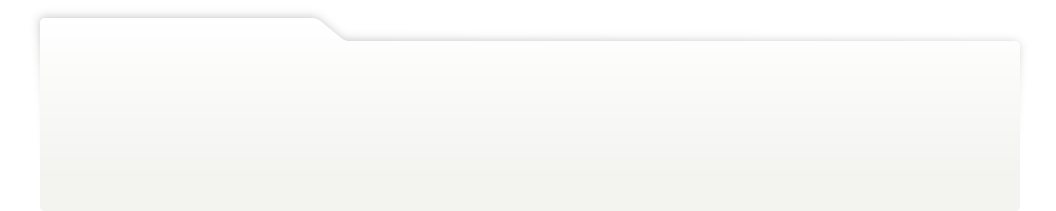
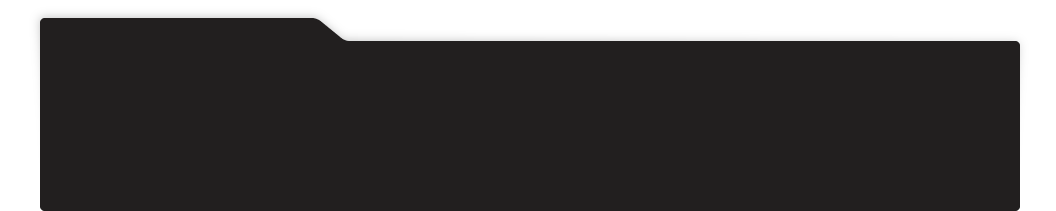
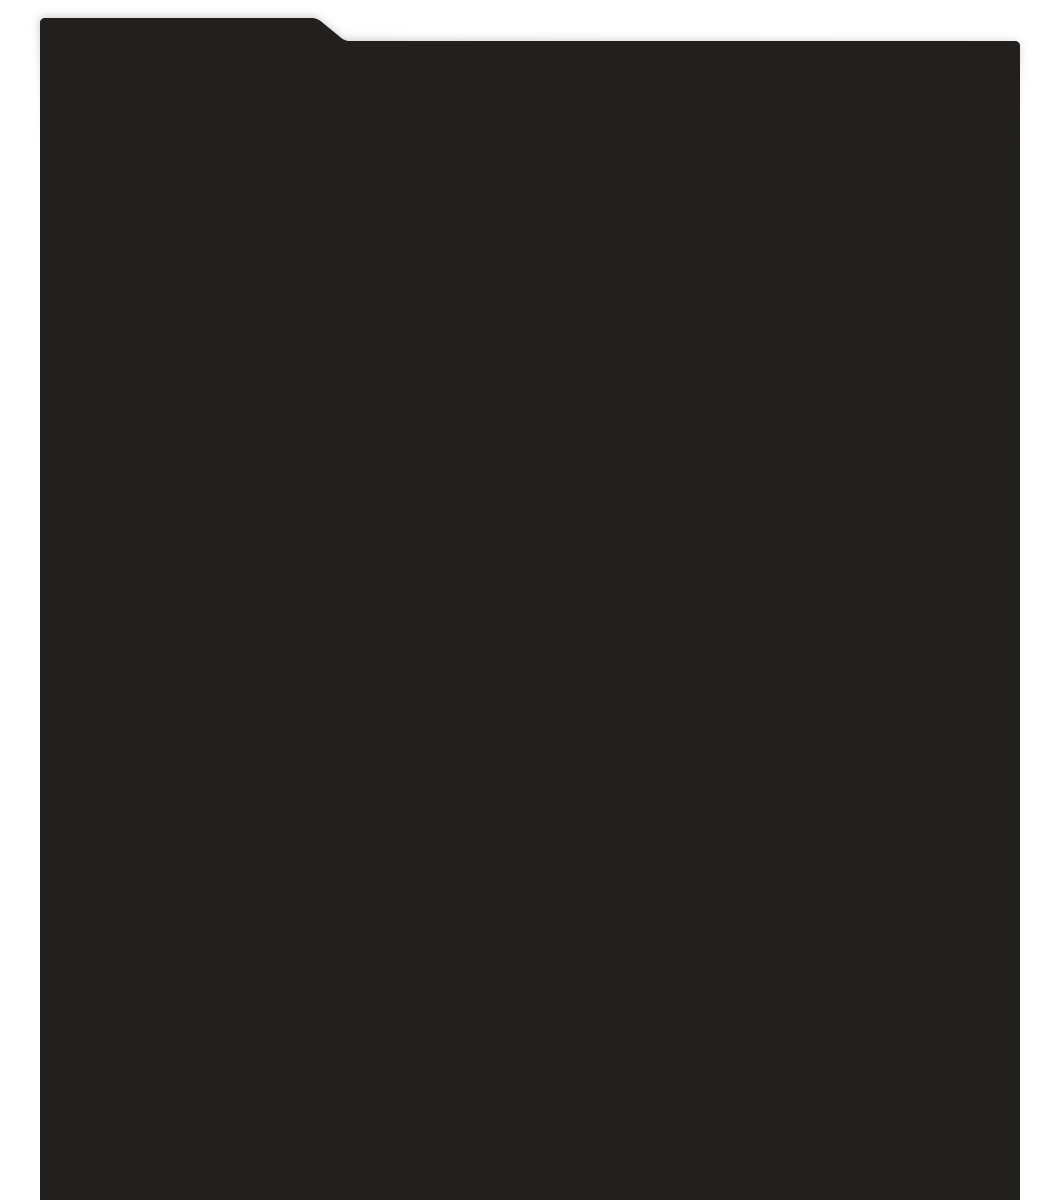
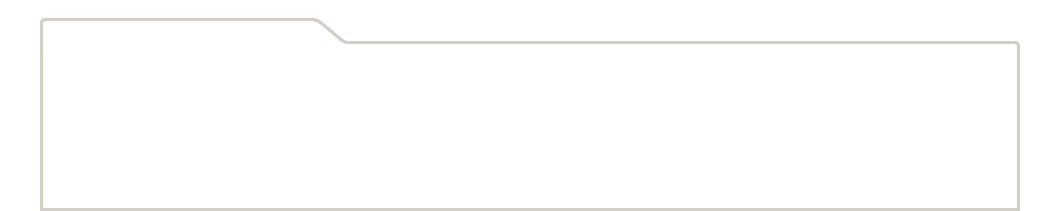
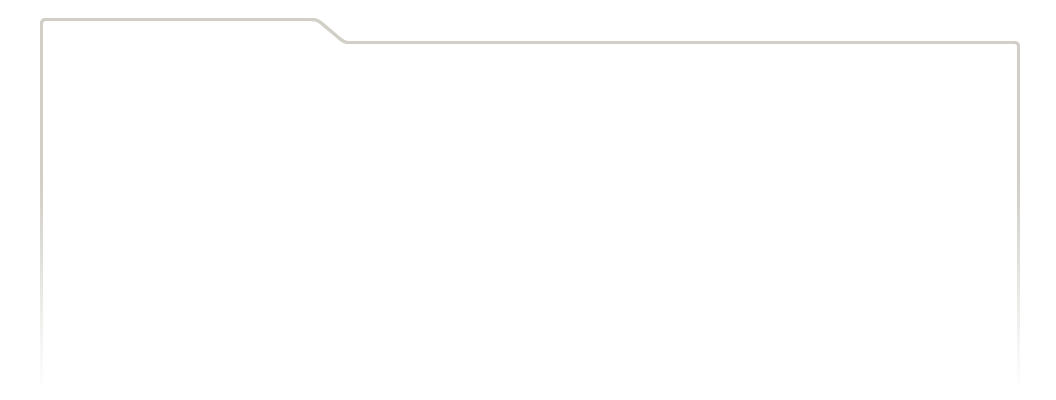
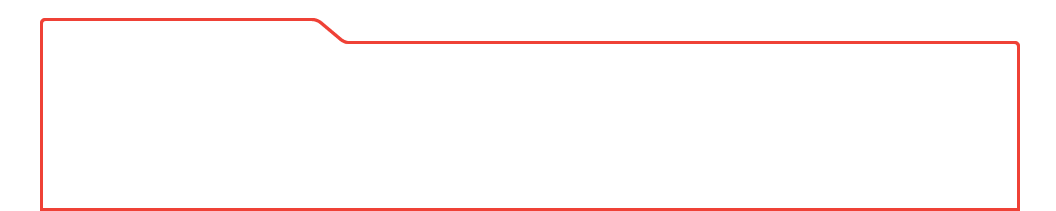
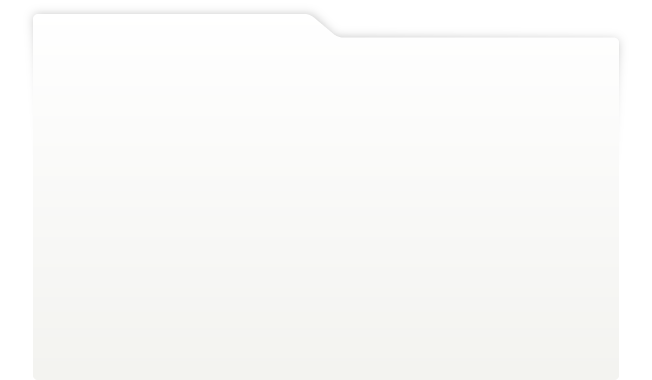
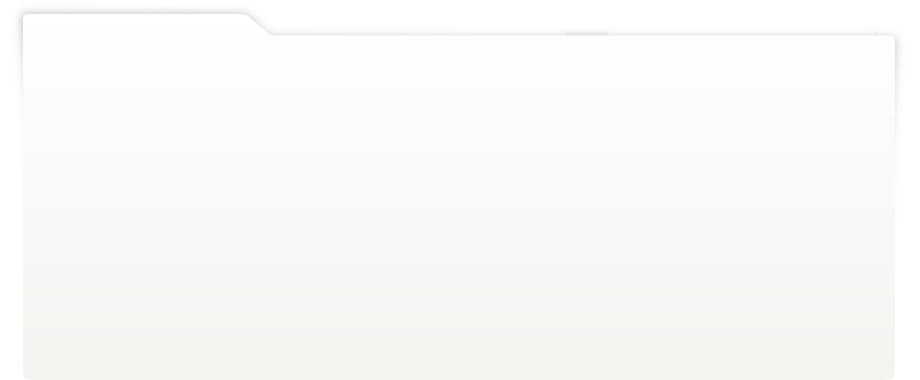
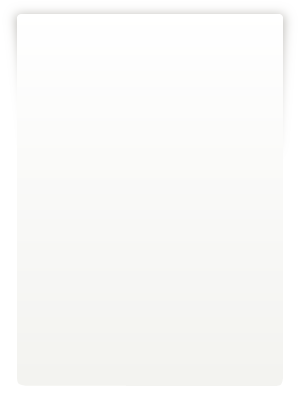
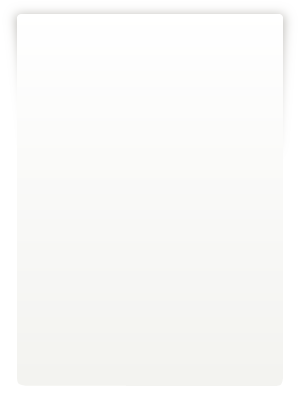
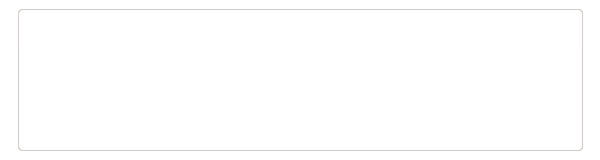
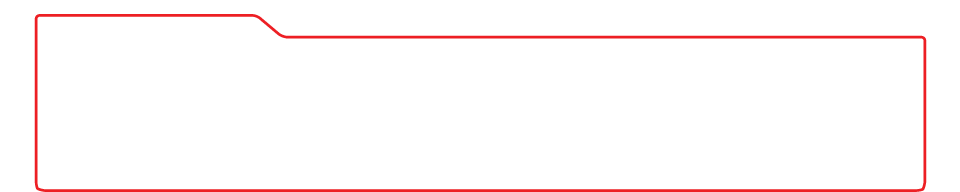
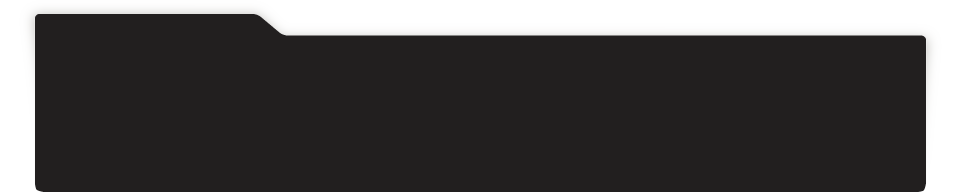
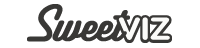
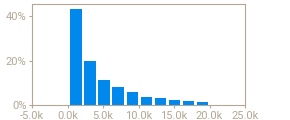
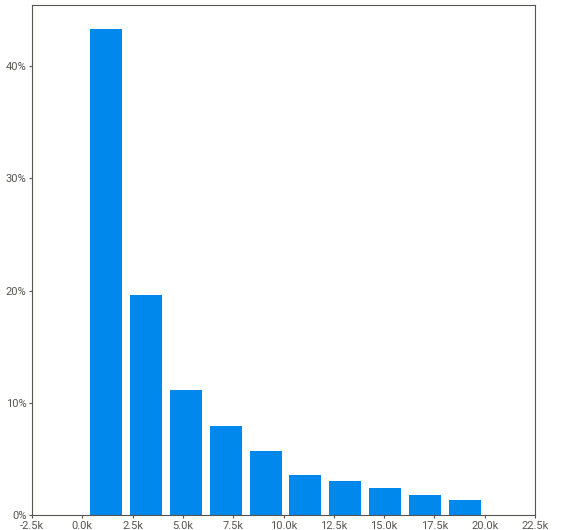
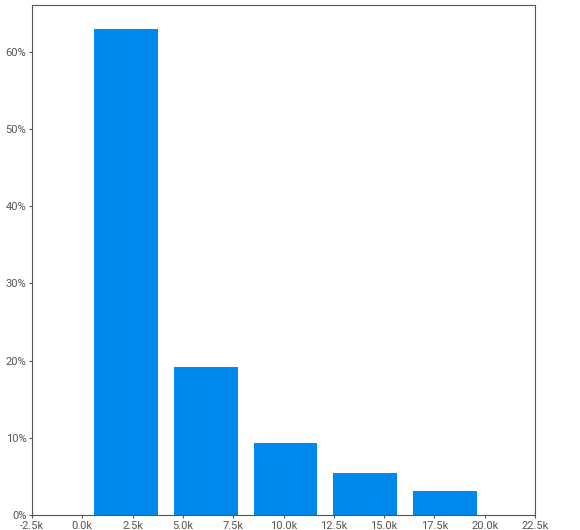
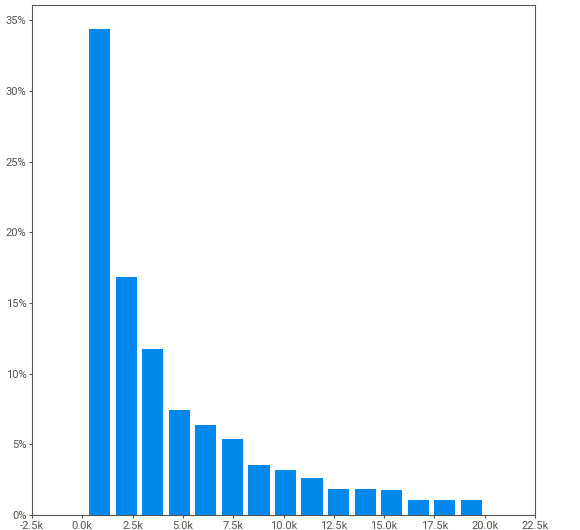
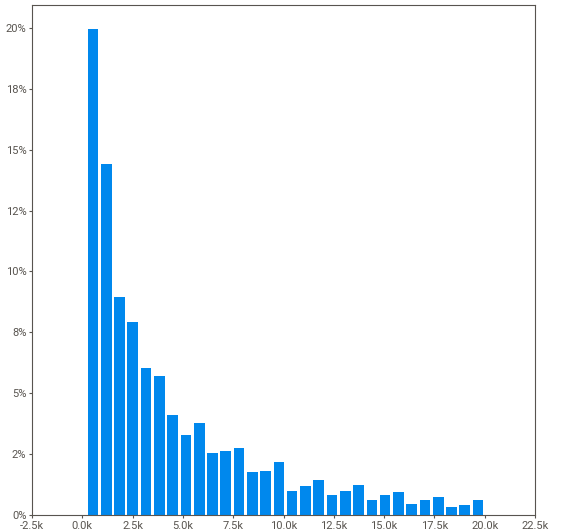
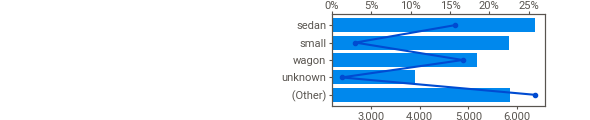
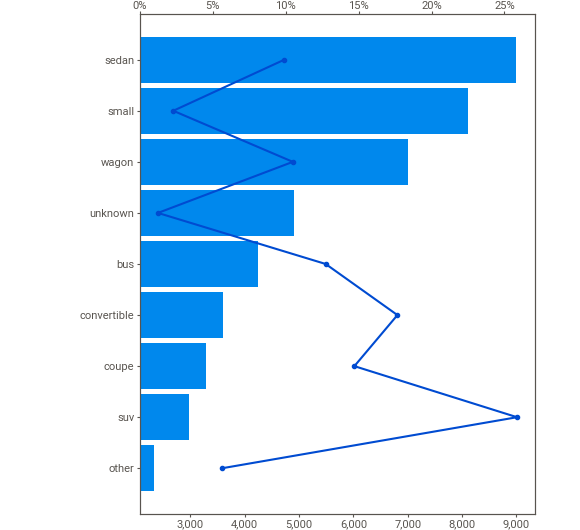
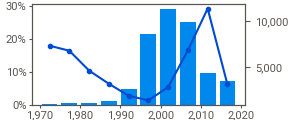
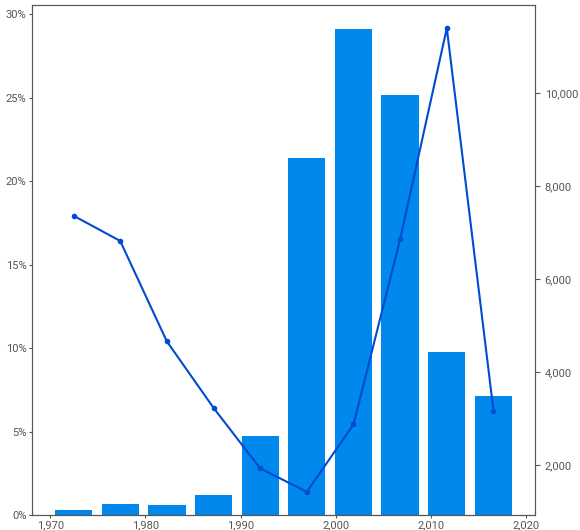
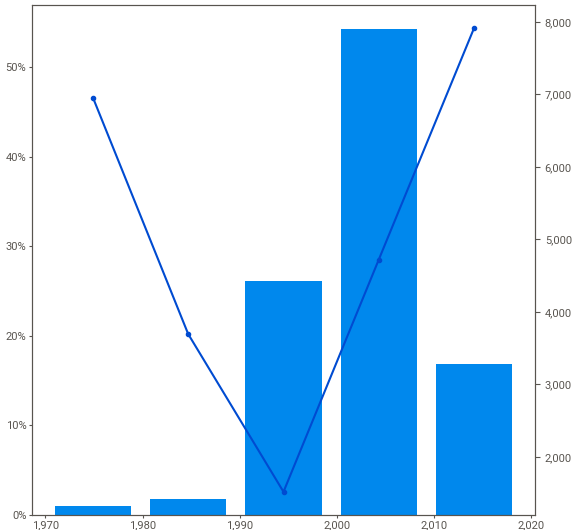
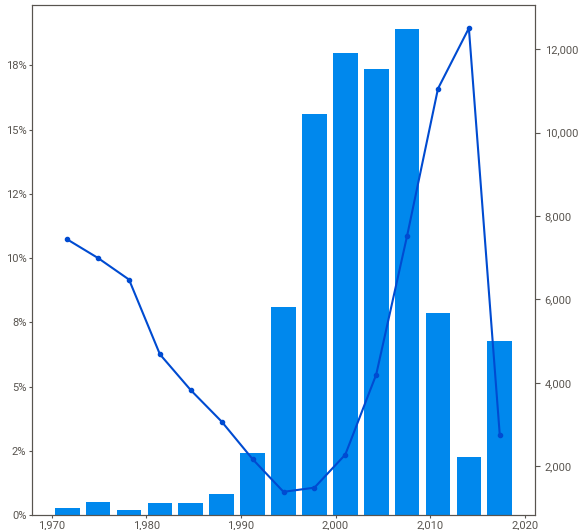
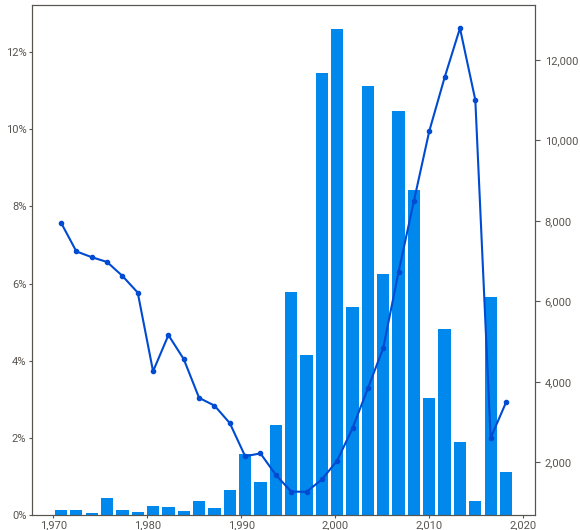
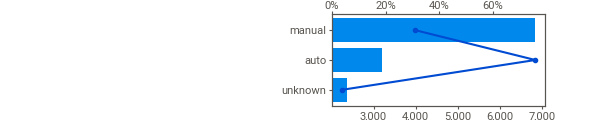
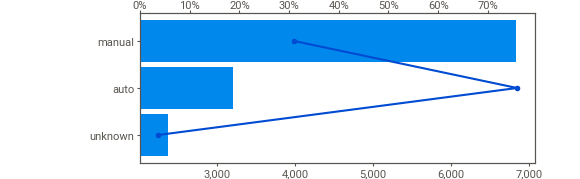
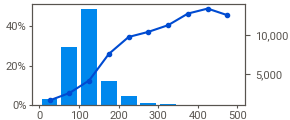
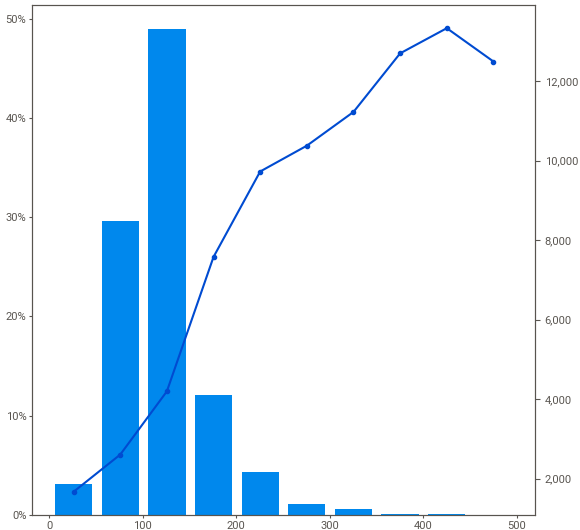
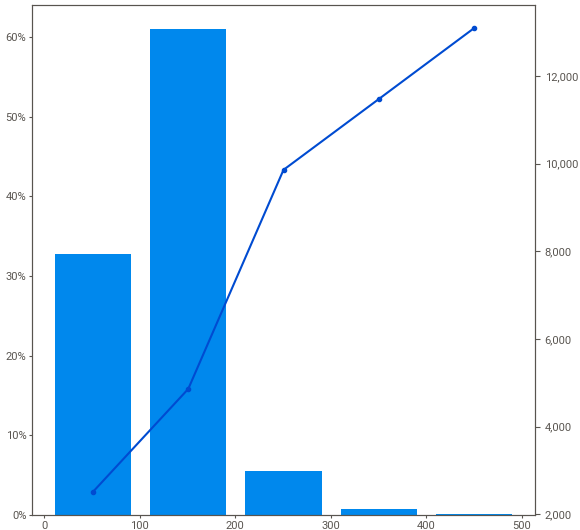
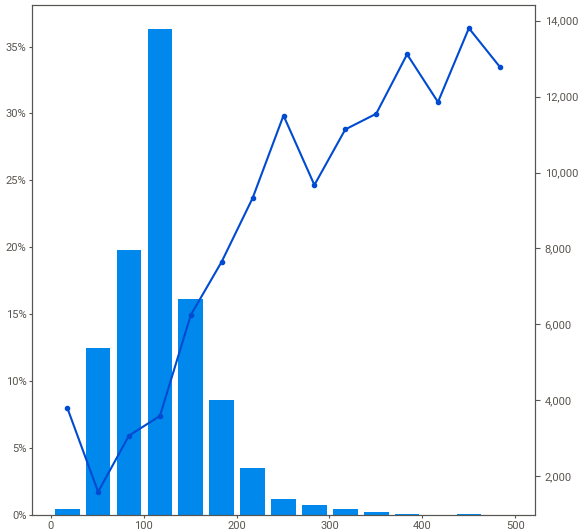
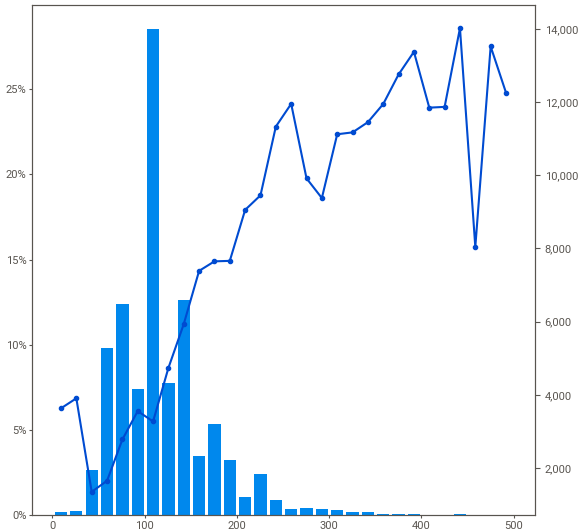
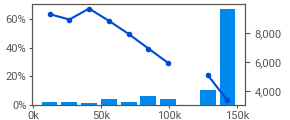
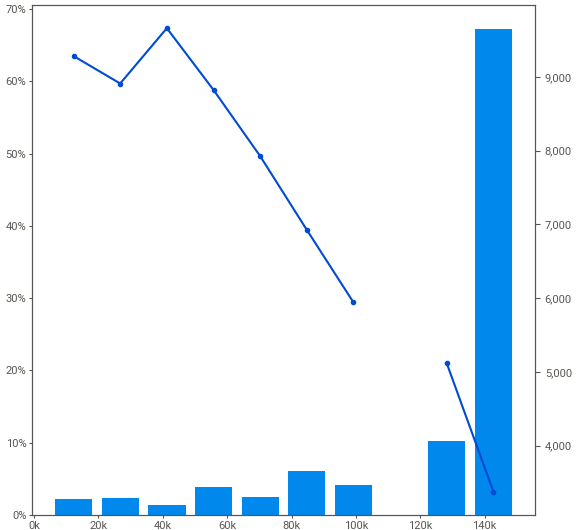
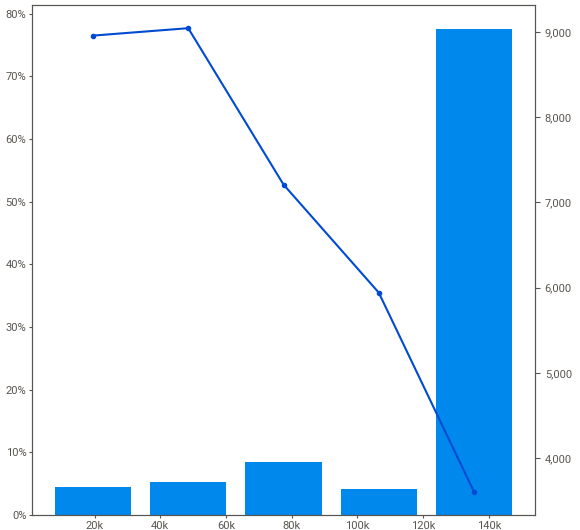
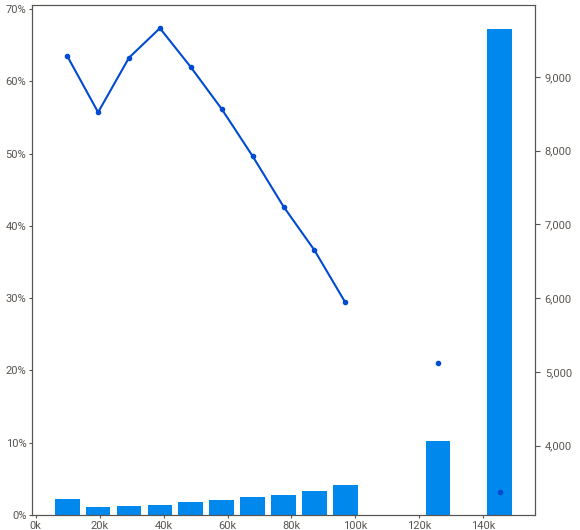
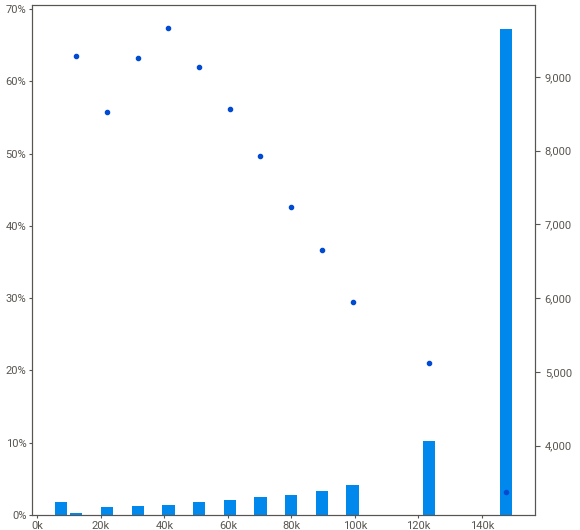
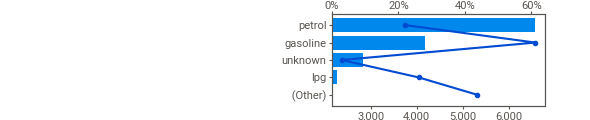
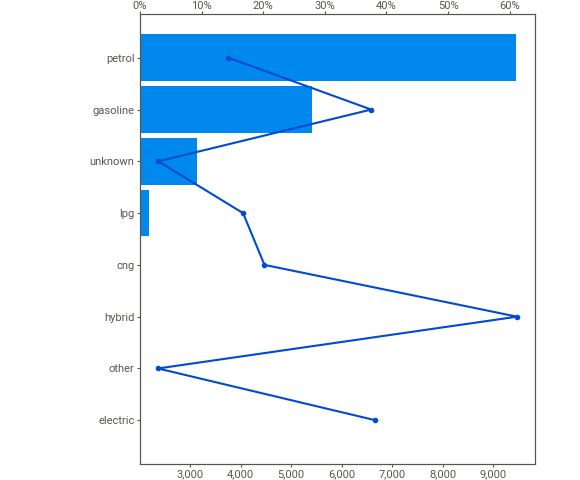
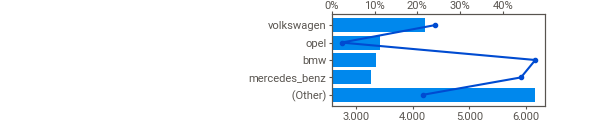
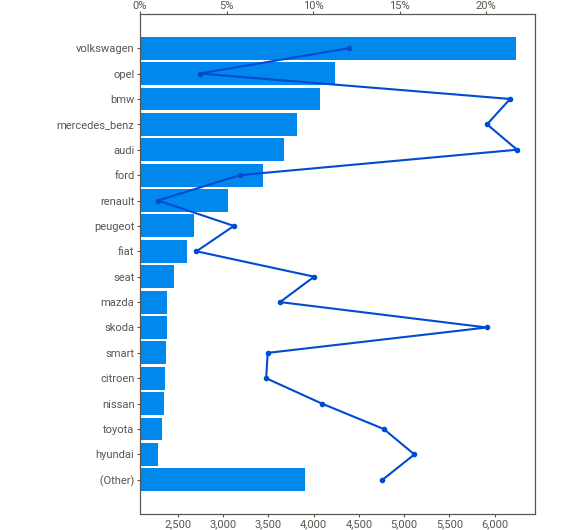
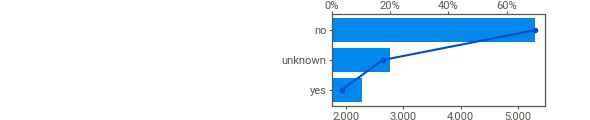
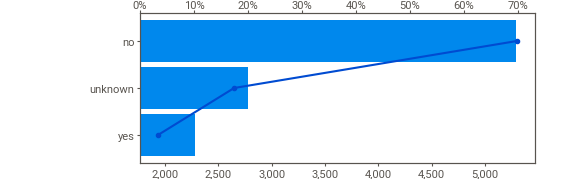
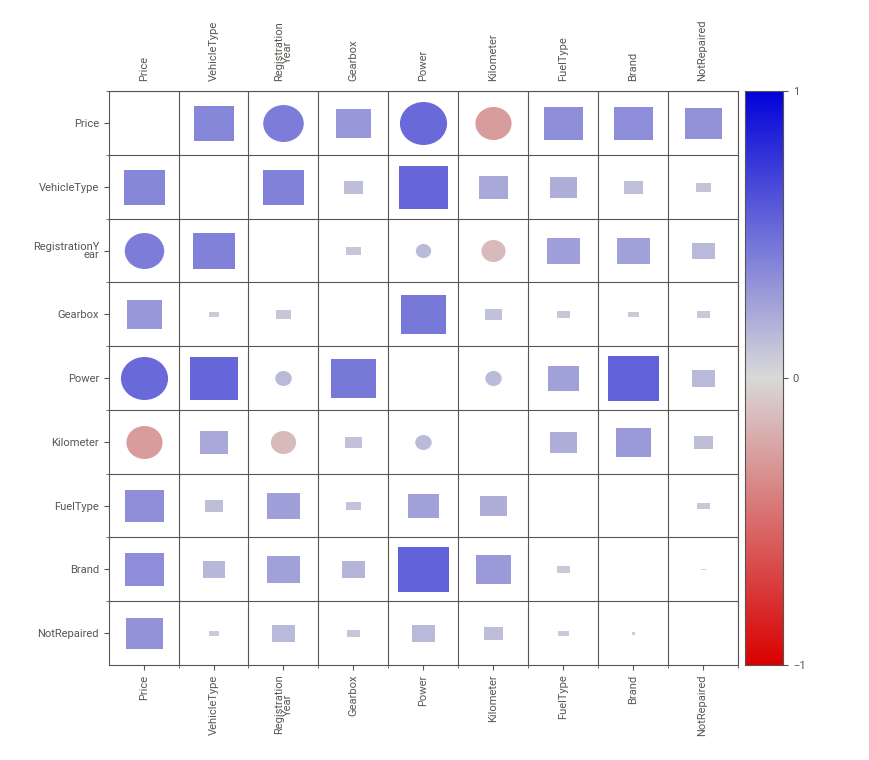
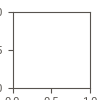

In [13]:
report_autos = sv.analyze((df, 'autos_df'), target_feat='Price')
report_autos.show_notebook()

Исследовательский анализ данных показывает, что заметное влияние на увеличение цены оказывает: наличие автоматической коробки передач, увеличение мощности двигателя, отсутствие ремонта. Также можно отметить, что некоторые бренды автомобилей, например, BMW и Mercedes-Benz намного отличаются по цене от других.

<div class='alert alert-success'> ✔️Молодец, что применяшь современные инструмента поиска особенностей в колонках датафрейма и влиянии значений на цель.
</div>

<div class='alert alert-warning'>⚠️ Как считаешь, есть ли аномалии в области низких значений цены?


</div>

<li>   <font color='steelblue'>«Низкие значения цены заменил на величину 5 процентиля данного столбца» </font>

## Анализ моделей

### Линейная регрессия

Закодируем категориальные данные методом OHE.

In [14]:
df_ohe = df.copy()
df_ohe = pd.get_dummies(df_ohe, drop_first=True)

print('Размер набора данных до OHE:', df.shape)
print('Размер набора данных после OHE:', df_ohe.shape)

Размер набора данных до OHE: (354369, 10)
Размер набора данных после OHE: (354369, 312)


<div class='alert alert-success'> ✔️Отлично, что в get_dummies используешь параметр  drop_first=True, который позволяет избавиться от фиктивных признаков.
</div>

Разделим данные на тренировочную и тестовую выборки

In [15]:
X_ohe = df_ohe.drop('Price', axis=1)
y_ohe = df_ohe['Price']

X_ohe_train, X_ohe_test, y_ohe_train, y_ohe_test = train_test_split(X_ohe, y_ohe, test_size=0.2, random_state=SEED)

idx_X_train = X_ohe_train.index
idx_y_train = y_ohe_train.index

idx_X_test = X_ohe_test.index
idx_y_test = y_ohe_test.index

<div class='alert alert-danger'>❌ Хорошо, создал две выборки: обучающую и валидационную. Валидационная нужна для отбора модели, на train выборке это делать неправильно, так как некоторые модели могут просто запомнить все решения и показать идеальный результат. А тест выборка используется для финального тестирования лучшей модели, ее больше ни для чего использовать нельзя (получается у нас ее пока нет). Поэтому: 
<li> Либо сделай три выборки - одну для обучения, другую для сравнения моделей между собой и третью для теста лучшей модели (просто добавь еще train_test_split). Чтобы создать одно разбиение вне зависимости от способа обработки выборок, можешь делать <a href='https://teletype.in/@dt_analytic/ILlCaWreRgO'> как здесь </a>
<li> Либо во всех алгоритмах проводи внутреннюю кросс-валидацию на train выборке с gridsearch (ошибка хранится в атрибуте best_score_) или cross_val_score. Тестовую не используй вплоть до финального тестирования лучшей модели 

</div>

<li>   <font color='steelblue'>«Будем использовать кросс-валидацию. Данные разделим один раз, затем будем делить по полученным индексам» </font>

Создадим конвейер для определения лучших гиперпараметров модели.

In [16]:
# pipe_lr = Pipeline([('scaler', StandardScaler()),
#                     ('lr', ElasticNet())])
#
# params_lr = {'lr__l1_ratio': [0, 1],
#              'lr__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000],
#              'lr__fit_intercept': [True, False]}
#
# grid_search_lr = GridSearchCV(estimator=pipe_lr,
#                               param_grid=params_lr,
#                               cv=5,
#                               n_jobs=-1,
#                               verbose=1)
#
# grid_search_lr.fit(X_ohe_train, y_ohe_train)
# grid_search_lr.best_params_

Создадим модель с лучшими гиперпараметрами и оценим ее время работы и качество.

In [17]:
pipe_lr = Pipeline([('scaler', StandardScaler()),
                    ('lr', ElasticNet(max_iter=10000))])

params_lr = {'lr__l1_ratio': [1],
             'lr__alpha': [0.1],
             'lr__fit_intercept': [True]}

grid_search_lr = GridSearchCV(estimator=pipe_lr,
                              param_grid=params_lr,
                              scoring='neg_root_mean_squared_error',
                              cv=5,
                              n_jobs=-1,
                              verbose=1)

In [18]:
%%time
print('Время обучения ElasticNet на тренировочной выборке (cv=5):')
grid_search_lr.fit(X_ohe_train, y_ohe_train)

best_lr = grid_search_lr.best_estimator_

Время обучения ElasticNet на тренировочной выборке (cv=5):
Fitting 5 folds for each of 1 candidates, totalling 5 fits
CPU times: total: 6min 48s
Wall time: 19min 54s


In [19]:
print('RMSE модели ElasticNet на тренировочной выборке (cv=5): {}'
      .format(int(abs(grid_search_lr.best_score_))))

RMSE модели ElasticNet на тренировочной выборке (cv=5): 2696


In [20]:
%%time
print('Время предсказания ElasticNet на тестовой выборке:')
y_lr_pred = best_lr.predict(X_ohe_test)

Время предсказания ElasticNet на тестовой выборке:
CPU times: total: 656 ms
Wall time: 198 ms


<div class='alert alert-success'> ✔️Засекаешь время корректно и на fit, и на predict.
</div>


In [21]:
rmse_lr = mean_squared_error(y_ohe_test, y_lr_pred, squared=False)
print('RMSE модели ElasticNet на тестовой выборке:', int(rmse_lr))

RMSE модели ElasticNet на тестовой выборке: 2697


### Случайный лес

Присвоим строковым значениям индивидуальные метки.

In [22]:
df_cat = df.copy()

for col in cat_cols:
    df_cat[col + '_LE'] = LabelEncoder().fit_transform(df[col])

df_le = df_cat[[col for col in df_cat if col not in cat_cols]]
df_le.head()

,Price,RegistrationYear,Power,Kilometer,VehicleType_LE,Gearbox_LE,Model_LE,FuelType_LE,Brand_LE,NotRepaired_LE
0,480.0,1993,105,150000,7,1,116,6,38,1
1,18300.0,2011,190,125000,2,1,228,2,1,2
2,9800.0,2004,163,125000,6,0,117,2,14,1
3,1500.0,2001,75,150000,5,1,116,6,38,0
4,3600.0,2008,69,90000,5,1,101,2,31,0


Разделим данные на тренировочную и тестовую выборки. Будем использовать полученные ранее индексы, чтобы избежать ошибок идентичности.

In [23]:
X_le = df_le.drop('Price', axis=1)
y_le = df_le['Price']

X_le_train, X_le_test, y_le_train, y_le_test = X_le.loc[idx_X_train], X_le.loc[idx_X_test], \
                                               y_le.loc[idx_y_train], y_le.loc[idx_y_test]

<div class='alert alert-warning'>⚠️Чтобы исключить ошибки идентичности разбиения правильно делать это один раз  (<a href='https://teletype.in/@dt_analytic/ILlCaWreRgO'> как здесь </a>)

</div>


Создадим конвейер для определения лучших гиперпараметров модели.

In [24]:
# params_rf = {'n_estimators': [50, 100, 200, 300],
#              'max_depth': [1, 2, 4, 6, 8, 10, 12]}
#
# grid_search_rf = GridSearchCV(estimator=RandomForestRegressor(random_state=SEED),
#                               param_grid=params_rf,
#                               cv=5,
#                               n_jobs=-1,
#                               verbose=1)
#
# grid_search_rf.fit(X_le_train, y_le_train)
# grid_search_rf.best_params_

Создадим модель с лучшими гиперпараметрами и оценим ее время работы и качество.

In [25]:
params_rf = {'n_estimators': [300],
             'max_depth': [12]}

grid_search_rf = GridSearchCV(estimator=RandomForestRegressor(random_state=SEED),
                              param_grid=params_rf,
                              scoring='neg_root_mean_squared_error',
                              cv=5,
                              n_jobs=-1,
                              verbose=1)

In [26]:
%%time
print('Время обучения RandomForestRegressor на тренировочной выборке (cv=5):')
grid_search_rf.fit(X_le_train, y_le_train)

best_rf = grid_search_rf.best_estimator_

Время обучения RandomForestRegressor на тренировочной выборке (cv=5):
Fitting 5 folds for each of 1 candidates, totalling 5 fits
CPU times: total: 1min 28s
Wall time: 3min 20s


In [27]:
print('RMSE модели RandomForestRegressor на тренировочной выборке (cv=5): {}'
      .format(int(abs(grid_search_rf.best_score_))))

RMSE модели RandomForestRegressor на тренировочной выборке (cv=5): 1901


In [28]:
%%time
print('Время предсказания RandomForestRegressor на тестовой выборке:')
y_rf_pred = best_rf.predict(X_le_test)

Время предсказания RandomForestRegressor на тестовой выборке:
CPU times: total: 1.78 s
Wall time: 1.79 s


In [29]:
rmse_rf = mean_squared_error(y_le_test, y_rf_pred, squared=False)
print('RMSE модели RandomForestRegressor на тестовой выборке:', int(rmse_rf))

RMSE модели RandomForestRegressor на тестовой выборке: 1914


### Градиентный бустинг

Создадим конвейер для определения лучших гиперпараметров модели.

In [30]:
# params_gb = {'n_estimators': [50, 100, 200, 300],
#              'max_depth': [1, 2, 4, 6, 8, 10, 12],
#              'learning_rate': [0.0001, 0.001, 0.01, 0.1, 1]}
#
# grid_search_gb = GridSearchCV(estimator=LGBMRegressor(random_state=SEED),
#                               param_grid=params_gb,
#                               cv=5,
#                               n_jobs=-1,
#                               verbose=1)
#
# grid_search_gb.fit(X_le_train, y_le_train)
# grid_search_gb.best_params_

Создадим модель с лучшими гиперпараметрами и оценим ее время работы и качество.

In [31]:
params_gb = {'n_estimators': [300],
             'max_depth': [10],
             'learning_rate': [0.1]}

grid_search_gb = GridSearchCV(estimator=LGBMRegressor(random_state=SEED),
                              param_grid=params_gb,
                              scoring='neg_root_mean_squared_error',
                              cv=5,
                              n_jobs=-1,
                              verbose=1)

In [32]:
%%time
print('Время обучения LGBMRegressor на тренировочной выборке (cv=5):')
grid_search_gb.fit(X_le_train, y_le_train)

best_gb = grid_search_gb.best_estimator_

Время обучения LGBMRegressor на тренировочной выборке (cv=5):
Fitting 5 folds for each of 1 candidates, totalling 5 fits
CPU times: total: 8.89 s
Wall time: 6.45 s


In [33]:
print('RMSE модели LGBMRegressor на тренировочной выборке (cv=5): {}'
      .format(int(abs(grid_search_gb.best_score_))))

RMSE модели LGBMRegressor на тренировочной выборке (cv=5): 1769


In [34]:
%%time
print('Время предсказания LGBMRegressor на тестовой выборке:')
y_gb_pred = best_gb.predict(X_le_test)

Время предсказания LGBMRegressor на тестовой выборке:
CPU times: total: 1.41 s
Wall time: 126 ms


In [35]:
rmse_gb = mean_squared_error(y_le_test, y_gb_pred, squared=False)
print('RMSE модели LGBMRegressor на тестовой выборке:', int(rmse_gb))

RMSE модели LGBMRegressor на тестовой выборке: 1775


### Сравнение результатов

In [36]:
results_df = pd.DataFrame({'Time_fit_(cv=5)': ['6min 42s', '1min 26s', '9.48 s'],
                           'Time_predict': ['812 ms', '1.75 s', '1.28 s'],
                           'RMSE_train_(cv=5)': [int(abs(grid_search_lr.best_score_)),
                                               int(abs(grid_search_rf.best_score_)),
                                               abs(grid_search_gb.best_score_).round(1)],
                           'RMSE_test': [int(rmse_lr), int(rmse_rf), int(rmse_gb)]},

                          index=['ElasticNet', 'RandomForest', 'LGBMRegressor'])

results_df

,Time_fit_(cv=5),Time_predict,RMSE_train_(cv=5),RMSE_test
ElasticNet,6min 42s,812 ms,2696.0,2697
RandomForest,1min 26s,1.75 s,1901.0,1914
LGBMRegressor,9.48 s,1.28 s,1769.0,1775


Анализ трех разных моделей показывает, что лидером является модель градиентного бустинга LGBMRegressor. Она обладает наилучшими характеристиками в скорости обучения и предсказания (скорость предсказания только немного уступает линейной регрессии) и наименьшим значением метрики RMSE, меньшим требуемого значения 2500.

<div class='alert alert-warning'>⚠️Хорошие результаты. Рекомендовал бы оформлять их в более наглядном виде, например, в форме датафрейма, чтобы произвести дополнительное впечатление на читателя.

</div>

<div class='alert alert-danger'>❌Давай здесь проведем финальное тестирование лучшей модели на еще не использованной выборке (писал выше). 
</div>

<li>   <font color='steelblue'>«Определил RMSE с помощью кросс-валидации на обучающей выборке и на тестовой» </font>

## Важность признаков

Оценим важность признаков для модели градиентного бустинга с помощью пакета SHAP.

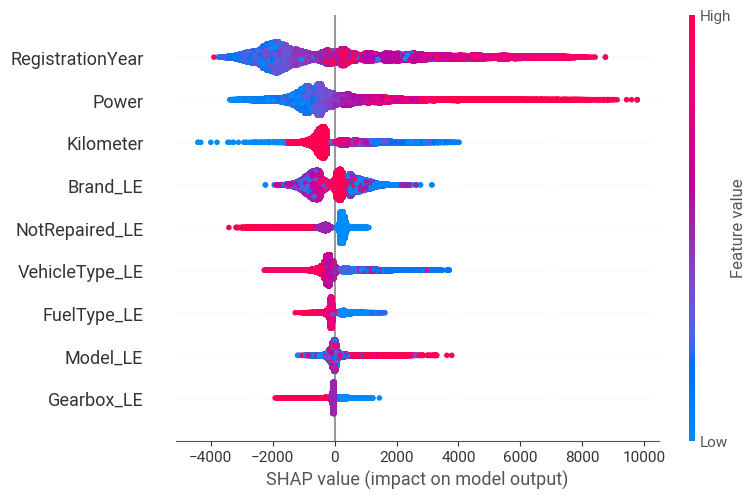

In [37]:
shap_gb = shap.TreeExplainer(best_gb).shap_values(X_le_train)
shap.summary_plot(shap_gb, X_le_train, plot_size='auto')

Значения слева от центральной вертикальной линии показывают тенденцию к уменьшению цены автомобиля, а справа к увеличению. Чем толще участок горизонтальной линии, тем больше подобных образцов. Цвет горизонтальной линии соответствует величине признака (чем ближе к красному, тем выше и соответственно чем ближе к синему тем меньше).

Можно видеть, что наибольшее влияние на цену автомобиля оказываю год регистрации и мощность двигателя. Чем выше эти величины, т.е. чем мощнее автомобиль и чем он новее тем выше будет его цена. Пробег автомобиля не оказывает однозначного влияния на цену, автомобили с низким пробегом могут обладать, как высокой, так и низкой ценой. Также можно интерпретировать признаки с малым количеством меток: отсутствие ремонта приводит к удорожанию автомобиля так же как и наличие автоматической коробки передач. Признаки с большим количеством меток интерпретировать затруднительно.

<div class='alert alert-success'> ✔️Отличный анализ важности признаков.
</div>

## Вывод

- В работе проанализирована скорость работы и точность предсказаний моделей линейной регрессии, случайного леса и градиентного бустинга при определении цены автомобиля. Показано, что наилучшими характеристиками быстродействия и точности обладает модель градиентного бустинга. Обучение - 10 сек, предсказание - 1,3 сек, величина RMSE - 1775.
- Наибольшее влияние на цену автомобиля оказывает год регистрации и мощность двигателя (чем выше тем дороже), а также отсутствие ремонта и наличие автоматической коробки передач.

<div class='alert alert-info'>🏁 Проделана большая и качественная работа! Исследовал и предобработал признаки, рассмотрел 3 модели и 2 способа кодирования, сделал перебор гиперпараметров, строил красивые визуализации, корректно засек время работы. Осталось разобраться с выборками, сделать финальное тестирование лучшей модели и дать обратную связь по выделенным ячейкам.


</div>

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [X]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [X]  Есть анализ скорости работы и качества моделей